## HW2
#### Author: Juliette Decugis, Vinay Gautam, Adam Mills, Chenxi Yao

#### Import package and data

In [1]:
import pandas as pd
import numpy as np
from os.path import join as oj
import datatable as dt

In [3]:
DATA_DIR = '~/Downloads/poplar_climate_GWAS_data Homework Assigned'

# 1. Load in data

### 1.1 SNP data

In [4]:
snp_orig_dt = dt.fread(oj(DATA_DIR, "869_NoCal_CR0.99.tagSNPs_BigLD0.70.txt"))

In [5]:
snp_orig_dt.shape

(869, 786075)

In [6]:
snp_orig_dt[:, :10].head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A
,▪▪▪▪,▪▪▪▪,▪,▪,▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,BESC-418,BESC-418,0,0,0,−9,1,2,2,2
1,BESC-52,BESC-52,0,0,0,−9,2,1,2,2
2,BESC-79,BESC-79,0,0,0,−9,2,1,NA,2
3,BESC-246,BESC-246,0,0,0,−9,NA,NA,2,2
4,BESC-313,BESC-313,0,0,0,−9,2,1,2,1
5,BESC-460,BESC-460,0,0,0,−9,2,0,2,2
6,GW-10958,GW-10958,0,0,0,−9,2,1,2,2
7,DENA-17-3,DENA-17-3,0,0,0,−9,2,0,2,2
8,VNDL-27-4,VNDL-27-4,0,0,0,−9,2,0,2,2


#### Quick look at the number of NAs in the SNP data

In [6]:
na_col_counts = snp_orig_dt.countna()  # get number of NAs per column
pd.DataFrame(na_col_counts.to_numpy().T).describe()

,0
count,786075.000000
mean,1.650722
std,2.205017
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,8.000000


#### Converting datatable to pandas dataframe

In [7]:
snp_orig = snp_orig_dt.to_pandas()

In [8]:
snp_orig.iloc[:, :10].head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A
0,BESC-418,BESC-418,False,False,False,-9,1.0,2.0,2.0,2.0
1,BESC-52,BESC-52,False,False,False,-9,2.0,1.0,2.0,2.0
2,BESC-79,BESC-79,False,False,False,-9,2.0,1.0,NaN,2.0
3,BESC-246,BESC-246,False,False,False,-9,NaN,NaN,2.0,2.0
4,BESC-313,BESC-313,False,False,False,-9,2.0,1.0,2.0,1.0


### 1.2 Response data

In [9]:
cloud_dens_orig = pd.read_csv(oj(DATA_DIR, "cloud_dens_yearAvg"), sep="\t", header=None)
tmin_orig = pd.read_csv(oj(DATA_DIR, "tmin_yearAvg"), sep="\t", header=None)

In [10]:
cloud_dens_orig.shape

(869, 3)

In [11]:
cloud_dens_orig.head()

,0,1,2
0,BESC-418,BESC-418,0.693175
1,BESC-52,BESC-52,-0.025059
2,BESC-79,BESC-79,0.151925
3,BESC-246,BESC-246,-0.929824
4,BESC-313,BESC-313,-0.689698


In [12]:
tmin_orig.shape

(869, 3)

In [13]:
tmin_orig.head()

,0,1,2
0,BESC-418,BESC-418,0.377185
1,BESC-52,BESC-52,0.391660
2,BESC-79,BESC-79,0.490293
3,BESC-246,BESC-246,0.080623
4,BESC-313,BESC-313,0.467125


#### Checking if the samples in X, tmin, and cloud_dens in the same order

In [14]:
tmin_orig[0].equals(cloud_dens_orig[0])

True

In [15]:
tmin_orig[0].equals(snp_orig["FID"])

True

# 2 Basic Data Cleaning
## 2.1 Cloud_dens_orig

In [16]:
y = cloud_dens_orig[2]

In [109]:
# Print cloud density data
y

0      0.693175
1     -0.025059
2      0.151925
3     -0.929824
4     -0.689698
         ...   
864    1.303344
865    1.303344
866    0.836930
867    1.929748
868    1.929748
Name: 2, Length: 869, dtype: float64

In [17]:
X = snp_orig.drop(columns=["FID", "IID", "PAT", "MAT", "SEX", "PHENOTYPE"]).sample(n=8000, axis=1)
X.shape

(869, 8000)

In [41]:
# get rid of samples with y = NA
X = X[~y.isna()]
y = y[~y.isna()]

In [42]:
X.shape, y.shape

((869, 8000), (869,))

## 2.1 tmin_orig

In [86]:
y2 = tmin_orig[2]

In [87]:
y2

0      0.377185
1      0.391660
2      0.490293
3      0.080623
4      0.467125
         ...   
864   -0.431626
865   -0.431626
866   -0.742362
867    1.454448
868    1.454448
Name: 2, Length: 869, dtype: float64

In [50]:
X2 = snp_orig.drop(columns=["FID", "IID", "PAT", "MAT", "SEX", "PHENOTYPE"]).sample(n=8000, axis=1, random_state = 1)
X2.shape

(869, 8000)

In [91]:
# get rid of samples with y = NA
X2 = X2[~y2.isna()]
y2 = y2[~y2.isna()]

In [92]:
X2.shape, y2.shape

((787, 8000), (787,))

# 3. Prediction Modeling

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import r2_score, mean_squared_error

## Data splitting
### 3.1 Cloud Density

In [132]:
# note: the following does NOT do a 60-20-20% train-valid-test split
# cloud density
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=331)

In [22]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((556, 8000), (556,), (139, 8000), (139,), (174, 8000), (174,))

In [44]:
imputer = SimpleImputer(strategy="most_frequent")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = KNNImputer()
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('rf', RandomForestRegressor())])

In [45]:
ypred_valid = pipe.predict(X_valid)

In [26]:
mean_squared_error(y_valid, ypred_valid)

0.8832715473267992

In [27]:
r2_score(y_valid, ypred_valid)

0.2504343832519683

In [28]:
pipe.score(X_valid, y_valid)

0.2504343832519683

#### Different imputation methods, followed by either an untuned random forest or lasso

In [106]:
imputers = {
    "simple_imputer": SimpleImputer(strategy="most_frequent"),
    "knn_imputer": KNNImputer(),
    # "iterative_imputer": IterativeImputer(max_iter=10, random_state=0)
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso()
}

pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe
pipes

{'simple_imputer+rf': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'simple_imputer+lasso': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('lasso', Lasso())]),
 'knn_imputer+rf': Pipeline(steps=[('knn_imputer', KNNImputer()),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'knn_imputer+lasso': Pipeline(steps=[('knn_imputer', KNNImputer()), ('lasso', Lasso())])}

In [48]:
valid_errs = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_train, y_train)
    valid_errs[pipe_name] = pipe.score(X_valid, y_valid)
valid_errs

simple_imputer+rf
simple_imputer+lasso
knn_imputer+rf
knn_imputer+lasso


{'simple_imputer+rf': 0.275797321917584,
 'simple_imputer+lasso': -5.466587662650291e-05,
 'knn_imputer+rf': 0.2850098012091111,
 'knn_imputer+lasso': -5.466587662650291e-05}

#### Add CV to tune hyperparameters

In [30]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    "knn_imputer__n_neighbors": [2, 5, 10]
}

In [31]:
valid_errs = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search = GridSearchCV(pipe, cv_param_grid)
    pipe_search.fit(X_train, y_train)
    valid_errs[pipe_name] = pipe_search.score(X_valid, y_valid)
valid_errs

simple_imputer+rf
simple_imputer+lasso
knn_imputer+rf
knn_imputer+lasso


{'simple_imputer+rf': 0.2936561177260717,
 'simple_imputer+lasso': 0.4027961514529389,
 'knn_imputer+rf': 0.26632114468578716,
 'knn_imputer+lasso': 0.4108366859284882}

From the result above, we can tell lasso is the best combined with KNN, however, KNN takes lots of computation power and it has a result close to simple imputer. Therefore, we use simple imputer and lasso as our choice for cloud density.

#### Refitting the model for cloud density

In [69]:
pipe2 = Pipeline(steps=[('simple_imputer', SimpleImputer(strategy="most_frequent")), ('lasso', Lasso(alpha = .01))])

In [70]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                ('lasso', Lasso(alpha=0.01))])

In [142]:
pipe2.score(X_test, y_test)

0.43038686910283286

In [71]:
ypred_valid2 = pipe2.predict(X_valid)
print(ypred_valid2)

[ 0.38362621 -0.54182861 -0.26513294 -0.09144086 -1.63901161 -0.81560128
  0.36158452 -0.03708505 -0.64050201  0.12990347  0.448411   -0.14934707
  0.0151414  -0.49331089 -0.51001036  0.17054467  0.9008817   0.83937335
 -1.64719567  0.3423671  -0.71192526  0.28749428  0.65818941 -0.34312286
 -1.16376705  0.57002179  0.85802755 -1.00911028 -0.83722108 -0.03178052
 -0.26040783  0.25149134  1.31536907 -0.81290353 -1.02278066 -0.46144838
  0.41214645 -0.11084475 -1.51859768 -0.48907929  0.73286823 -0.78642173
  0.38631836  1.75494778  0.51973238 -0.20971153  0.00600023  0.23562943
  0.79452615  0.0445869   0.80047295  0.25438872 -0.1379638   0.06057494
  0.58912048 -0.98505592  0.34177154  0.69244811  0.64921148  0.58553342
  0.74228156 -1.45083855 -0.02363657 -1.42208933 -1.23083792  1.60400273
 -0.27206128 -0.49519636  1.0969544  -1.57994249  1.10720536  0.11254963
 -0.85245641  1.4003416  -0.53947029  0.31014999  0.61849152 -0.42370376
  0.57216772  0.12953575 -0.40898197  0.37442909  0

#### Fit model for X_train

In [74]:
coefs = pipe2.named_steps['lasso'].coef_
coefs = np.abs(coefs)
coefs.sort()
print(coefs[-5:])

[0.10600418 0.11446224 0.11833698 0.12735169 0.14595125]


### Important Features

In [75]:
sort = np.copy(coefs)
sort.sort()
for coef in sort[-5:]:
    print(X_train.columns.values[np.where(coefs == coef)[0][0]])

Chr17_11860996_G
Chr01_2695098_G
Chr15_13301112_G
Chr01_6180927_A
Chr14_15313077_C


We implemented a MLP to better predict cloud density based on our features. We used a simple imputation method where every missing value was replaced with a 0. We got better results with this imputation method than with KNN when using our MLP to predict cloud density.

In [129]:
imputer = SimpleImputer(strategy='constant')
X_train_cloud = imputer.fit_transform(X_train, y_train)
X_valid_cloud = imputer.transform(X_valid)
X_test_cloud = imputer.transform(X_test)

After experimenting on different hidden sizes and max number of iterations, we decide to use an MLP with two hidden layers (50x100) as it had the highest validation r^2 score. We use a small batch size of 32 as our training data only has 503 observations. We limit to 100 iterations to limit overfitting.

In [133]:
model_cloud = MLPRegressor(hidden_layer_sizes=(50,100,), batch_size = 32, learning_rate = 'adaptive', random_state = 1234, activation = "relu", solver = "adam", max_iter=100)
model_cloud.fit(X_train_cloud, y_train)

MLPRegressor(batch_size=32, hidden_layer_sizes=(50, 100),
             learning_rate='adaptive', max_iter=100, random_state=1234)

In [140]:
model_cloud.score(X_train_cloud, y_train), model_cloud.score(X_valid_cloud, y_valid)

(0.9986111092881156, 0.6672565960472936)

In [141]:
model_cloud.score(X_test_cloud, y_test)

0.5666171391768308

We observe that our best predictive model for predicting cloud density is the MLP with r squared score of 0.567 on our testing data. It outperforms naive RF and Lasso.

### 3.2 tmin_orig

In [94]:
# note: the following does NOT do a 60-20-20% train-valid-test split
# tmin_orig
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=1234)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=331)

In [95]:
X_train2.shape, y_train2.shape, X_valid2.shape, y_valid2.shape, X_test2.shape, y_test2.shape

((503, 8000), (503,), (126, 8000), (126,), (158, 8000), (158,))

In [96]:
imputer = SimpleImputer(strategy="most_frequent")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = KNNImputer()
pipe3 = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor())])
pipe3.fit(X_train2, y_train2)

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('rf', RandomForestRegressor())])

In [98]:
ypred_valid2 = pipe3.predict(X_valid2)

In [99]:
mean_squared_error(y_valid2, ypred_valid2)

0.12035077572975614

In [27]:
r2_score(y_valid2, ypred_valid2)

0.2504343832519683

In [101]:
pipe3.score(X_valid2, y_valid2)

0.2140312495990353

In [143]:
pipe3.score(X_test2, y_test2)

0.15416110955113194

Our baseline score with random forest is 0.154.

In [30]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    "knn_imputer__n_neighbors": [2, 5, 10]
}

In [110]:
valid_errs2 = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search = GridSearchCV(pipe, cv_param_grid)
    pipe_search.fit(X_train2, y_train2)
    valid_errs2[pipe_name] = pipe_search.score(X_valid2, y_valid2)
valid_errs2

simple_imputer+rf
simple_imputer+lasso
knn_imputer+rf
knn_imputer+lasso


{'simple_imputer+rf': 0.14134188398176828,
 'simple_imputer+lasso': 0.30374816054444964,
 'knn_imputer+rf': 0.16090260963434755,
 'knn_imputer+lasso': 0.28875471561363075}

From the result above, we can tell the combination of simple imputer and lasso is the best.

#### Refitting the model for tmin_orig

In [111]:
pipe4 = Pipeline(steps=[('simple_imputer', SimpleImputer(strategy="most_frequent")), ('lasso', Lasso(alpha = .01))])

In [112]:
pipe4.fit(X_train2, y_train2)

Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                ('lasso', Lasso(alpha=0.01))])

In [144]:
pipe4.score(X_test2, y_test2)

0.30159706813406295

Lasso outperform random forest on our test set for predicting tmin_orig.

In [113]:
ypred_valid3 = pipe4.predict(X_valid2)
print(ypred_valid2)

[ 0.41187825  0.43634677  0.29025796  0.12145748  0.21748829  0.16424872
  0.09048975  0.21568202  0.43803613  0.46674313  0.18051005  0.13824754
  0.36712276  0.23958336  0.28328437  0.42789142  0.31077525  0.34663868
  0.31779365  0.2776505   0.2207284   0.24444646  0.24349301  0.3723034
  0.25660477 -0.23277802  0.20023299  0.24713388  0.27452704  0.3238577
  0.20924961  0.24247813  0.31234331  0.32797205  0.36529122  0.31237305
  0.25048439  0.2157966   0.23599516  0.17660388  0.23186038  0.37069695
  0.31524871  0.29976617  0.38092748  0.34429171  0.37250358  0.25514861
  0.33483552  0.31184103  0.28387718  0.30547735  0.33722874  0.23150971
  0.28132877  0.29783723  0.19949043  0.36821465  0.33283099  0.25213019
  0.46973476  0.28211138  0.2319981   0.29392823  0.31815873  0.25185814
  0.31405807  0.25329004  0.35588259  0.09069464  0.36010692  0.1853263
  0.0879145   0.28586066  0.1998263   0.4362639   0.04899116  0.24285068
  0.34689889  0.39979603  0.21889158  0.24362181  0.39

#### Fit model for X_train

In [114]:
coefs2 = pipe4.named_steps['lasso'].coef_
coefs2 = np.abs(coefs2)
coefs2.sort()
print(coefs2[-5:])

[0.03564754 0.03796517 0.0440869  0.04992194 0.05818797]


### Important Features

In [117]:
sort2 = np.copy(coefs2)
sort2.sort()
for coef in sort2[-5:]:
    print(X_train2.columns.values[np.where(coefs2 == coef)[0][0]])

Chr12_7324830_T
Chr19_304224_T
Chr13_14117394_G
Chr01_13568277_C
Chr18_3006007_T


We decided to implement a Multilayer Perceptron to predict minimum annual temperature based on the tree genotypes. 

We decide to use a simple imputer since it worked well with our previous predictive models. We replaced all missing values with 0 therefore assuming missing genes did not variate from the norm.

In [118]:
imputer = SimpleImputer(strategy='constant')
X_train_temp = imputer.fit_transform(X_train2, y_train2)
X_valid_temp = imputer.transform(X_valid2)
X_test_temp = imputer.transform(X_test2)

In [119]:
from sklearn.neural_network import MLPRegressor

We used the same MLP as previously as it also gave us the highest score:

In [122]:
model = MLPRegressor(hidden_layer_sizes=(50,100,), batch_size = 32, learning_rate = 'adaptive', random_state = 1234, activation = "relu", solver = "adam", max_iter=100)
model.fit(X_train_temp, y_train2)

MLPRegressor(batch_size=32, hidden_layer_sizes=(50, 100),
             learning_rate='adaptive', max_iter=100, random_state=1234)

We display our training and validation r^2:

In [123]:
model.score(X_train_temp, y_train2)

0.9963256131211797

In [124]:
model.score(X_valid_temp, y_valid2)

0.3509745564785275

We observe a large drop in scores from our training r^2 and validation r^2 which demonstrates our model does overfit to our data. We tried lowering the number of iterations and increasing batch size to reduce overfitting but that resulted in lower validation scores. Our MLP still beats all other models on the validation set so we decide to deploy it on our test set:

In [125]:
model.score(X_test_temp, y_test2)

0.36961568904600484

To understand our model errors using other metrics we compare the train, validation and testing MSE:

In [126]:
def mse(y_pred, y_actual):
    return np.mean((y_pred-y_actual)**2)

In [127]:
train_pred = model.predict(X_train_temp)
mse_train = mse(train_pred, y_train2)

val_pred = model.predict(X_valid_temp)
mse_val = mse(val_pred, y_valid2)

test_pred = model.predict(X_test_temp)
mse_test = mse(test_pred, y_test2)

In [128]:
mse_train, mse_val, mse_test

(0.0005683788723458275, 0.09938145194234478, 0.07217083498806695)

Our MLP as our best predictive model has testing MSE of 0.0722 on the t_min_orig dataset.

# 4. Graphics and Important Features

### 4.1 Feature Importance within our MLP

We want to understand what tree genotypes help in the prediction of our MLP. To calculate the feature importance of a given feature, we permute that feature and observe the mse loss as compared to our original model. We calculate the average over 10 permutations of each of the 8,000 features in our model. We can compute this as our MLP is small so it trains quickly.

A higher score corresponds to higher feature importance since if we permute that feature, the MLP performs worst on our data.

In [145]:
def get_feature_importance(j, n, model, X, y, baseline):
    # j-th feature, n - # of permutations
    # X - feature, y - label, baseline: score of our model using X to predict y
    total = 0.0
    for i in range(n):
        # select the indices to permute
        perm = np.random.permutation(range(X.shape[0]))
        X_ = X.copy()
        X_[:, j] = X_[perm, j] # X_ corresponds to the permuted copy of X
        s_ij = model.score(X_, y)
        total += s_ij
    return baseline - total / n

In [147]:
f = []
r_2_valid = model.score(X_valid_temp, y_valid2)

for i in range(X_valid_temp.shape[1]):
    if i%100 == 0:
        print(i)
    f_i = get_feature_importance(i, 10, model, X_valid_temp, y_valid2, r_2_valid)
    f.append(f_i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900


In [149]:
importance_scores = pd.Series(f)
importance_scores = importance_scores.sort_values(ascending=False)
importance_scores.head()

2517    0.006238
5913    0.005474
7002    0.004728
5550    0.004639
2579    0.004463
dtype: float64

We therefore identify variants on these features as most important in our MLP predictions based on r squarred scores after permutations:

In [150]:
importance_scores = pd.Series(f)
X.columns[importance_scores.index[:10]]

Index(['Chr01_49208247_G', 'Chr07_1005439_C', 'Chr02_3746317_C',
       'Chr12_9349802_C', 'Chr01_17557236_C', 'Chr11_16155998_G',
       'Chr18_12037494_T', 'Chr06_25940449_C', 'Chr13_15659086_G',
       'Chr07_6250910_A'],
      dtype='object')

### Variants: Chr13_14989013_C, Chr16_347680_T and Chr01_24259832_C 

### 4.2 Interesting Variants Plots

We draw plots to understand how these variants correlate with minimum annual temperature:

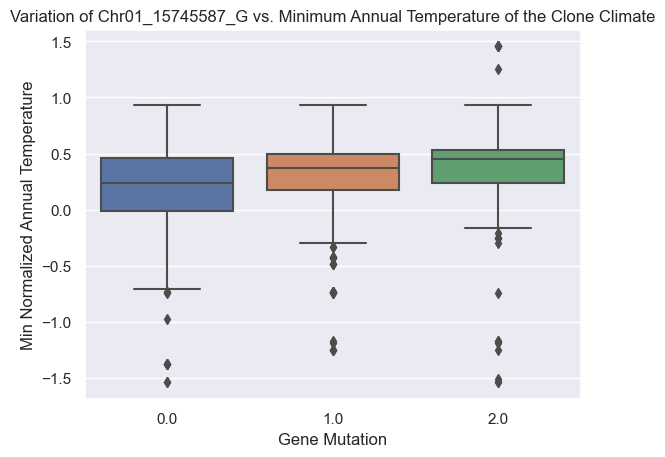

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.boxplot(x=X2.iloc[:, 2517], y=y2)
plt.xlabel('Gene Mutation')
plt.ylabel('Min Normalized Annual Temperature')
plt.title('Variation of ' + X.columns[2517] + ' vs. Minimum Annual Temperature of the Clone Climate')
plt.show()

We observe that a larger variant on Chr13_14989013_C often correlates with higher climate temperature. Indeed, on our plot for SNP = 0 we have average minimum annual temperature closer to the mean whereas for SNP = 2, they are 1 standard deviation away from the mean. We also notice most clones that live in climates with high temperatures (more than one standard deviation from the mean) have SNP = 2 for Chr13_14989013_C.

We wanted to understand what other variants are correlated with variants on Chr13_14989013_C. We calculated the correlation of that feature and all others in the dataset and looked at the top correlations:

In [159]:
test = X2.iloc[:, 2517]
snp_cor = np.abs(X2.corrwith(test))
sort = snp_cor.sort_values(ascending=False)
sort.head(5)

Chr13_14989013_C    1.000000
Chr11_8301773_C     0.169304
Chr04_24193047_T    0.151736
Chr14_7742501_C     0.150271
Chr13_488792_C      0.148158
dtype: float64

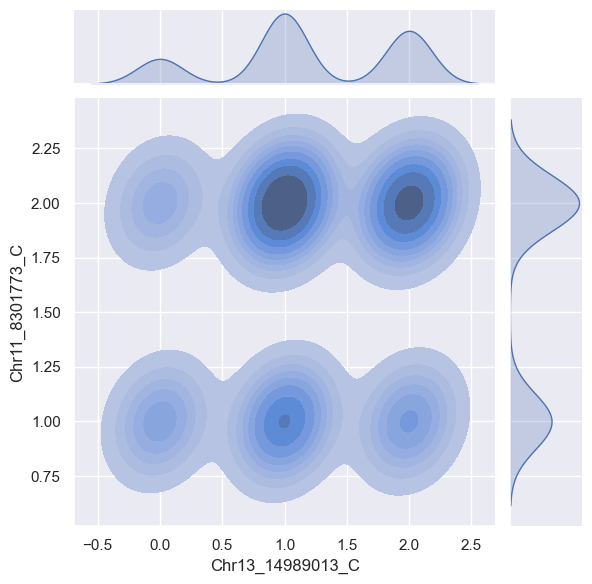

In [182]:
sns.jointplot(x = X2.loc[:, 'Chr13_14989013_C'], y=X2.loc[:, 'Chr11_8301773_C'], kind = 'kde', fill=True)
# plt.title('Distribution of ' + X.columns[1068] + ' Variants vs. ' + X.columns[2517] + ' Variants');

We compare the distribution of variants on Chr13_14989013_C and Chr11_8301773_C. We observe that variants in Chr13_14989013_C seem correlated with variants in Chr11_8301773_C as we have the highest overlap in SNP = 1 or 2 for Chr13_14989013_C and SNP = 2 for Chr11_8301773_C.

In [170]:
X2.columns[1068], X2.columns[2517]

('Chr13_488792_C', 'Chr13_14989013_C')

We then plotted the combined effects of variations on Chr13_488792_C and Chr13_14989013_C on minimum annual temperature. Our x-axis gives the variant strength for Chr13_488792_C combined with different variant strengths on Chr13_14989013_C for each group. 

When we have high variants on both features (SNP = 2 for both, last green boxplot) we observe higher minimum annual temperature values. When both variants have SNP of 0 we observe lower annual minimum temperature values. Therefore the combined effects of these features seems to play a role in predicting minimum annual temperature of the climate.

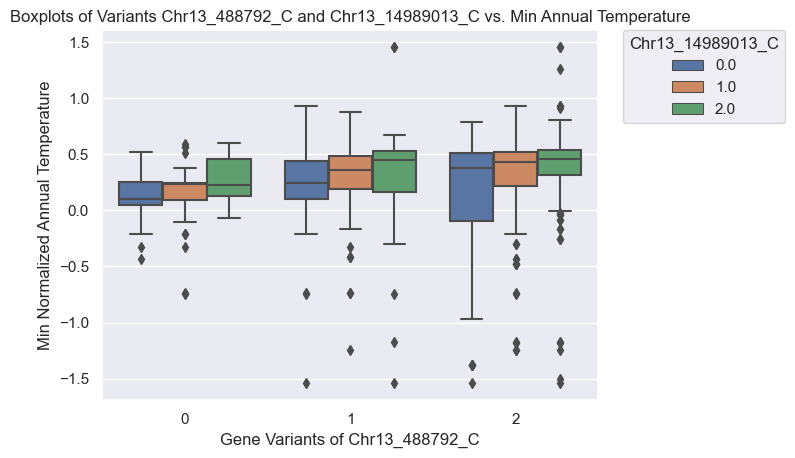

In [185]:
sns.set(style="darkgrid")
sns.boxplot(x=X2.iloc[:, 1068], hue=X2.iloc[:,2517], y=y2)
plt.xlabel('Gene Variants of Chr13_488792_C')
plt.ylabel('Min Normalized Annual Temperature')
plt.title('Boxplots of Variants Chr13_488792_C and Chr13_14989013_C vs. Min Annual Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title = 'Chr13_14989013_C')
plt.show()

We then extracted our relavant features from LASSO and looked at their values for cloud density:

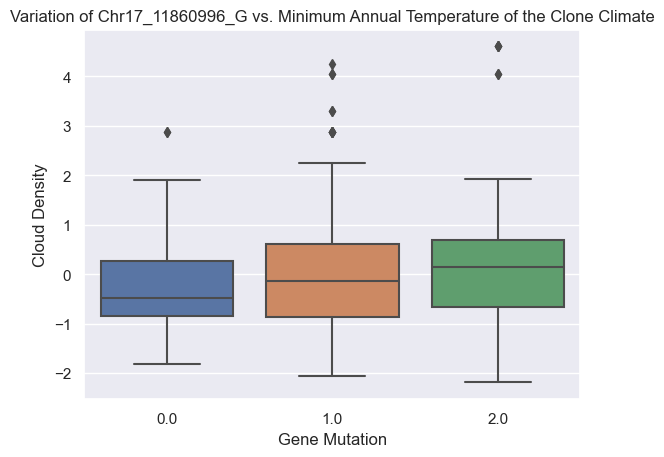

In [181]:
sns.set(style="darkgrid")
sns.boxplot(x=X.loc[:, 'Chr17_11860996_G'], y=y)
plt.xlabel('Gene Mutation')
plt.ylabel('Cloud Density')
plt.title('Variation of Chr17_11860996_G vs. Minimum Annual Temperature of the Clone Climate')
plt.show()

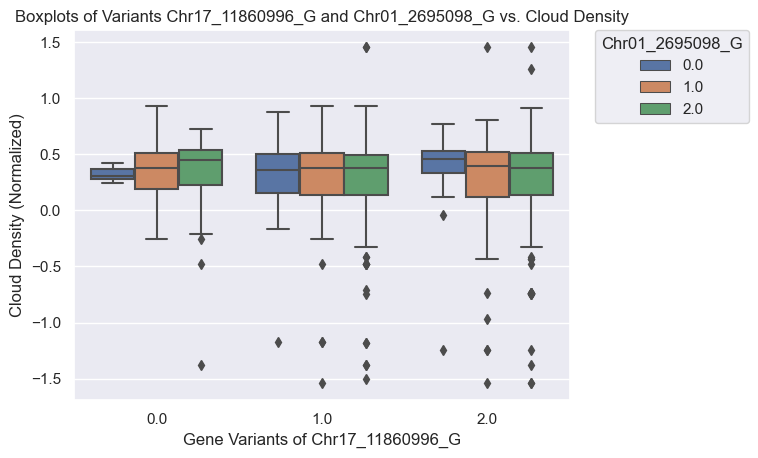

In [186]:
sns.set(style="darkgrid")
sns.boxplot(x=X.loc[:, 'Chr17_11860996_G'], hue=X.loc[:,'Chr01_2695098_G'], y=y2)
plt.xlabel('Gene Variants of Chr17_11860996_G')
plt.ylabel('Cloud Density (Normalized)')
plt.title('Boxplots of Variants Chr17_11860996_G and Chr01_2695098_G vs. Cloud Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title = 'Chr01_2695098_G')
plt.show()